In [1]:
from generate_maps import load_s3dis_point_cloud, get_topologial_map

file_path = 'data/noXYZ_area_3_no_xyz/area_3/3d/pointcloud.mat'  
point_sum_points, point_sum_colors, scene_names = load_s3dis_point_cloud(file_path)
print("success load!")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Keys in the .mat file: ['Area_3']
Processing conferenceRoom_1...
Processing hallway_1...
Processing hallway_2...
Processing hallway_3...
Processing hallway_4...
Processing hallway_5...
Processing hallway_6...
Processing lounge_1...
Processing lounge_2...
Processing office_1...
Processing office_2...
Processing office_3...
Processing office_4...
Processing office_5...
Processing office_6...
Processing office_7...
Processing office_8...
Processing office_9...
Processing office_10...
Processing storage_1...
Processing storage_2...
Processing WC_1...
Processing WC_2...
success load!


In [2]:
print(point_sum_points[0].shape)

(1266990, 3)


In [2]:
import generate_maps
import importlib
importlib.reload(generate_maps)

top_view_map, obstacle_map, separate_obstacle_map, all_centers = generate_maps.get_top_view_map(point_sum_points, point_sum_colors, scene_names)



In [3]:
num_samples = 5
navigation_instruct1 = "send a classified file from an office to another office"
navigation_instruct2 = "send a fragile equipment from an office to a conference room"
navigation_instruct3 = "send a private medicine from an office to the bathroom"
navigation_instruct4 = "send an emergency file from an office to another office"

source_nodes = ["office_1", "office_8", "office_2"]
target_nodes = ["office_3", "conferenceRoom_1", "WC_2"]


s_start = all_centers[source_nodes[1]]
s_end = all_centers[target_nodes[1]]



In [5]:
print(s_start)

(785, 143)


In [82]:
from PIL import Image, ImageDraw, ImageFont
import random
import matplotlib.pyplot as plt
from io import BytesIO
import cv2
import matplotlib.pyplot as plt

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(15, 15))
ob_map = cv2.dilate((obstacle_map).astype('uint8'), kernel)

# plt.imshow(ob_map)
# plt.axis('off')  # 隐藏坐标轴
# plt.show()

pil_img = Image.fromarray(top_view_map)
draw = ImageDraw.Draw(pil_img)

font_size = 25
# Load a font (make sure you specify a valid .ttf font path on your system)
font = ImageFont.load_default(font_size)

# Number of circles to draw
num_labels = 50

# Circle radius
r = 20

# Image dimensions
height, width, _ = top_view_map.shape

i = 1
valid_points = {}
while i < num_labels: 
    # Generate random (x, y) within image boundaries
    x = random.randint(r, width - r)
    y = random.randint(r, height - r)
    
    if ob_map[y, x] == 1:
        continue
    
    # Check distance from all previously placed points
    too_close = False
    min_dist = 100
    for label_key, (px, py) in valid_points.items():
        if (y - px)**2 + (x - py)**2 < min_dist**2:
            too_close = True
            break
    
    # If this point is too close to an existing point, skip it
    if too_close:
        continue
    
    # Draw the circle
    draw.ellipse(
        [(x - r, y - r), (x + r, y + r)],
        fill="white",       # circle fill color
        outline="black",    # circle outline color
        width=2             # outline thickness
    )
    
    # Center the text inside the circle
    label = str(i)
    text_x = x - (font_size / 2)
    text_y = y - (font_size / 2)
    draw.text((text_x, text_y), label, fill="black", font=font)
    
    valid_points[str(i)] = (y, x)
    i += 1
    
    
# mark start and end
font_size = 30
# Load a font (make sure you specify a valid .ttf font path on your system)
font = ImageFont.load_default(font_size)
x = s_start[1]
y = s_start[0]
# Draw the circle
draw.ellipse(
    [(x - r, y - r), (x + r, y + r)],
    fill="white",       # circle fill color
    outline="red",    # circle outline color
    width=4             # outline thickness
)

# Center the text inside the circle
label = 'S'
text_x = x - (font_size / 3)
text_y = y - (font_size / 1.5)
draw.text((text_x, text_y), label, fill="red", font=font)
valid_points[label] = (y, x)


x = s_end[1]
y = s_end[0]
# Draw the circle
draw.ellipse(
    [(x - r, y - r), (x + r, y + r)],
    fill="white",       # circle fill color
    outline="red",    # circle outline color
    width=4             # outline thickness
)

# Center the text inside the circle
label = 'D'
text_x = x - (font_size / 3)
text_y = y - (font_size / 1.5)
draw.text((text_x, text_y), label, fill="red", font=font)
valid_points[label] = (y, x)

    
pil_img.show()
buffered = BytesIO()
pil_img.save(buffered, format="JPEG")

pil_obs = Image.fromarray(top_view_map)
pil_obs.show()
buffered_obs = BytesIO()
pil_obs.save(buffered_obs, format="JPEG")



(eog:118381): EOG-CRITICAL **: 13:49:31.459: eog_image_get_file: assertion 'EOG_IS_IMAGE (img)' failed

(eog:118381): GLib-GIO-CRITICAL **: 13:49:31.459: g_file_equal: assertion 'G_IS_FILE (file1)' failed


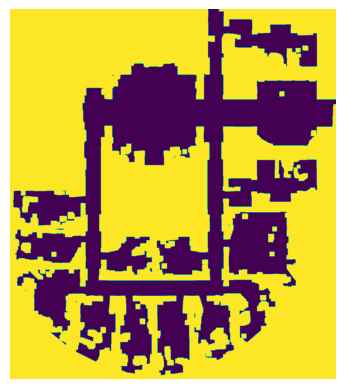

In [83]:
plt.imshow(ob_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [84]:
import system_prompt
import chat_utils
importlib.reload(system_prompt)
importlib.reload(chat_utils)

# message = chat_utils.generate_message_prepare(system_prompt.generate_path, buffered, buffered_obs, navigation_instruct2)
message = chat_utils.path_message_prepare(system_prompt.find_path_prompt, buffered, buffered_obs)

response_message = chat_utils.chat_with_gpt4v(message)

print(response_message)

ground_json = response_message["paths"]

gpt-4o response: 
{
  "observation": "From a close inspection of the actual corridors (avoiding all blacked‐out areas), there appear to be six truly walkable ways from S to D. They differ by whether one goes up the left hallway through the large lounge or straight along the center hall, and by whether the route loops briefly through the top corridor or the east café area en route to D.",
  "paths": [
    {
      "path_1": ["S", "47", "44", "14", "48", "3", "D"],
      "path_2": ["S", "47", "44", "14", "32", "20", "4", "D"],
      "path_3": ["S", "47", "44", "19", "5", "3", "D"],
      "path_4": ["S", "47", "44", "19", "32", "20", "4", "D"],
      "path_5": ["S", "1", "6", "14", "48", "3", "D"],
      "path_6": ["S", "1", "6", "14", "32", "20", "4", "D"]
    }
  ]
}
{'observation': 'From a close inspection of the actual corridors (avoiding all blacked‐out areas), there appear to be six truly walkable ways from S to D. They differ by whether one goes up the left hallway through the large

In [85]:
all_topo_paths = []
for k, v in ground_json[0].items():
    all_topo_paths.append(v)
print(all_topo_paths)

[['S', '47', '44', '14', '48', '3', 'D'], ['S', '47', '44', '14', '32', '20', '4', 'D'], ['S', '47', '44', '19', '5', '3', 'D'], ['S', '47', '44', '19', '32', '20', '4', 'D'], ['S', '1', '6', '14', '48', '3', 'D'], ['S', '1', '6', '14', '32', '20', '4', 'D']]


['S', '47', '44', '14', '48', '3', 'D']
['S', '47', '44', '14', '32', '20', '4', 'D']
['S', '47', '44', '19', '5', '3', 'D']
['S', '47', '44', '19', '32', '20', '4', 'D']
['S', '1', '6', '14', '48', '3', 'D']
['S', '1', '6', '14', '32', '20', '4', 'D']


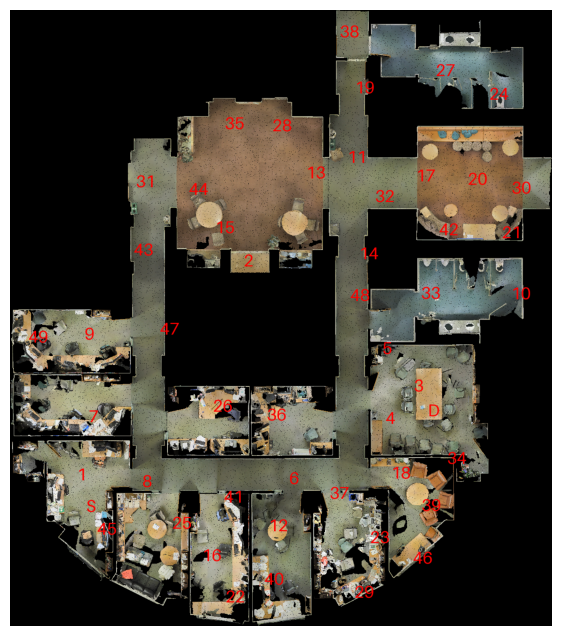

[[(732, 356), (733, 356), (734, 356), (735, 356), (736, 356), (737, 356), (738, 356), (739, 356), (740, 356), (741, 356), (742, 356), (743, 356), (744, 356), (745, 356), (746, 356), (747, 356), (748, 356), (749, 356), (750, 356), (751, 356), (752, 356), (753, 356), (754, 356), (755, 356), (756, 356), (757, 356), (758, 356), (759, 356), (760, 356), (761, 356), (762, 356), (763, 356), (764, 356), (765, 356), (766, 356), (767, 356), (768, 356), (769, 356), (770, 356), (771, 356), (772, 356), (773, 356), (774, 356), (775, 356), (776, 356), (777, 356), (778, 356), (779, 356), (780, 356), (781, 356), (782, 356), (783, 356), (784, 356), (785, 356), (786, 356), (787, 356), (788, 356), (789, 356), (790, 356), (791, 356), (792, 356), (793, 356), (794, 356), (795, 356), (796, 356), (797, 356), (798, 356), (799, 356), (800, 356), (801, 356), (802, 356), (803, 356), (804, 356), (805, 356), (806, 356), (807, 356), (808, 356), (809, 356), (810, 356), (811, 356), (812, 356), (813, 356), (814, 355), (8

In [87]:
import path_finding
importlib.reload(path_finding)
import matplotlib.pyplot as plt

all_geo_paths = path_finding.path_plan_from_topo_graph_for_large(all_topo_paths, obstacle_map, valid_points)

img = path_finding.write_scene_name(top_view_map, valid_points)
plt.figure(figsize=(10, 8)) 
plt.imshow(img)
plt.axis('off')  # 隐藏坐标轴
plt.show()
print(all_geo_paths)

In [ ]:
import numpy as np

for i, geo_path in enumerate(all_geo_paths):
    map_with_path = top_view_map.copy()
    x_indices, y_indices = zip(*geo_path)
    path_map = np.zeros(obstacle_map.shape)
    path_map[x_indices, y_indices] = 1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
    path_map = cv2.dilate((path_map).astype('uint8'), kernel)
    map_with_path[path_map == 1] = [255, 0 , 0]
    
    map_with_path = path_finding.write_number(map_with_path, i)
    buffered = BytesIO()
    map_with_path.save(buffered, format="JPEG")
    # candidate_map_list.append(buffered)

    # 使用 Matplotlib 显示图像
    # 使用 Matplotlib 显示图像.
    # map_with_path.save(save_directory+f"vis_{i}.png")
    plt.imshow(map_with_path)
    plt.axis('off')  # 隐藏坐标轴
    plt.show()

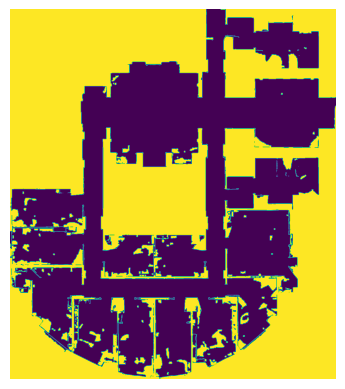

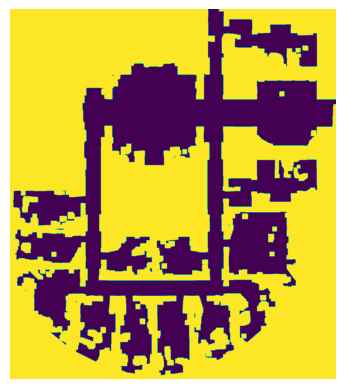

In [5]:
import cv2
import matplotlib.pyplot as plt

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(15, 15))
ob_map = cv2.dilate((obstacle_map).astype('uint8'), kernel)


plt.imshow(obstacle_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

plt.imshow(ob_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [6]:

# build topo map
# G = get_topologial_map(point_sum_points, scene_names)
# graph_show(G)


success load!


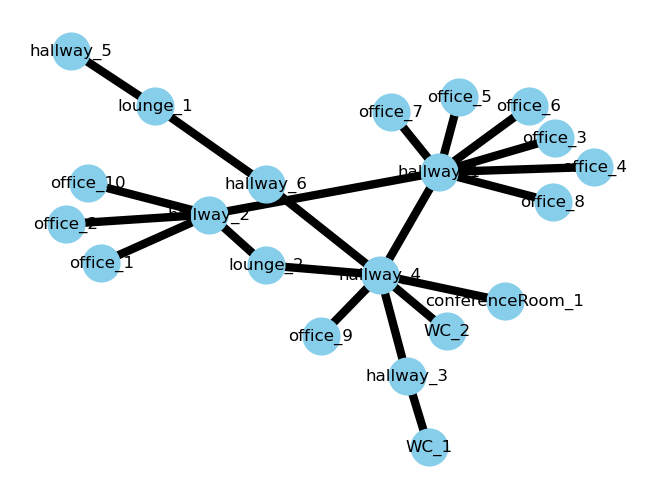

In [7]:
import os
import numpy as np
import pickle

filename = "3"

# print('Saving model to {}...'.format("saved_maps/"))
# if not os.path.exists("saved_maps/"):
#     os.makedirs("saved_maps/")
    
# graph_serialized = pickle.dumps(G)
# np.savez("saved_maps/" + filename +'_arrays.npz', graph=graph_serialized)
# print('Finished.')

file_path = f"saved_maps/{filename}_arrays.npz"  
data = np.load(file_path, allow_pickle=True)
graph_serialized = data['graph'].item()
G_loaded = pickle.loads(graph_serialized)
print("success load!")

path_finding.graph_show(G_loaded)

In [8]:
import networkx as nx
import cv2
import numpy as np
from io import BytesIO

importlib.reload(path_finding)

# all possible topo path searching

def get_all_candidate_maps(source_node, target_node):
    all_topo_paths = path_finding.get_all_simple_paths(G_loaded, source_node, target_node)
        
    all_geo_paths = path_finding.path_plan_from_topo_graph(all_topo_paths, obstacle_map, all_centers)

    save_directory = f"map_with_path/area_{filename}/{source_node}-{target_node}/"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    # show paths in map
    candidate_map_list = []
    for i, geo_path in enumerate(all_geo_paths):
        map_with_path = top_view_map.copy()
        x_indices, y_indices = zip(*geo_path)
        path_map = np.zeros(obstacle_map.shape)
        path_map[x_indices, y_indices] = 1
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
        path_map = cv2.dilate((path_map).astype('uint8'), kernel)
        map_with_path[path_map == 1] = [255, 0 , 0]
        
        map_with_path = path_finding.write_number(map_with_path, i)
        buffered = BytesIO()
        map_with_path.save(buffered, format="JPEG")
        candidate_map_list.append(buffered)

        # 使用 Matplotlib 显示图像
        # 使用 Matplotlib 显示图像.
        map_with_path.save(save_directory+f"vis_{i}.png")
        plt.imshow(map_with_path)
        plt.axis('off')  # 隐藏坐标轴
        plt.show()
        
    return candidate_map_list, all_geo_paths

In [9]:
importlib.reload(path_finding)
from PIL import Image

def get_metric(source_node, target_node, all_geo_paths):
    evaluation_map = path_finding.get_evaulation_map(separate_obstacle_map, source_node, target_node, scene_names, 15)

    office_obstacle_map_array = np.array(separate_obstacle_map)
    office_obstacle_map = np.max(office_obstacle_map_array, axis=0)

    # evaluation_map = Image.fromarray(evaluation_map)
    # evaluation_map.save(save_directory+f"metric.png")
    # plt.imshow(evaluation_map)
    # plt.axis('off')  # 隐藏坐标轴
    # plt.show()

    # plt.imshow(gaussian_modulation)
    # plt.axis('off')  # 隐藏坐标轴
    # plt.show()
    privacy_value_list = []
    distance_list = []
    for i, geo_path in enumerate(all_geo_paths):
        x_indices, y_indices = zip(*geo_path)
        # print(gaussian_modulation[x_indices[0], y_indices[0]])
        print(sum(evaluation_map[x_indices, y_indices]))
        print("distance: ", len(geo_path))
        privacy_value_list.append(sum(evaluation_map[x_indices, y_indices]))
        distance_list.append(len(geo_path))
        
    return privacy_value_list, distance_list

All paths from node office_1 to node office_3 :
2 ['office_1', 'office_3']
4 ['office_1', 'lounge_2', 'hallway_4', 'office_3']
2
['office_1', 'office_3']
['office_1', 'lounge_2', 'hallway_4', 'office_3']


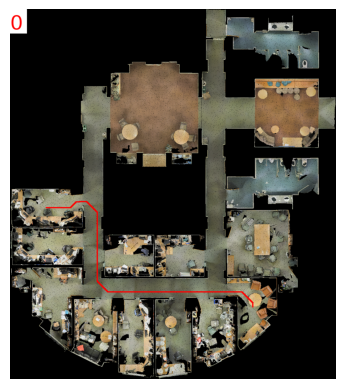

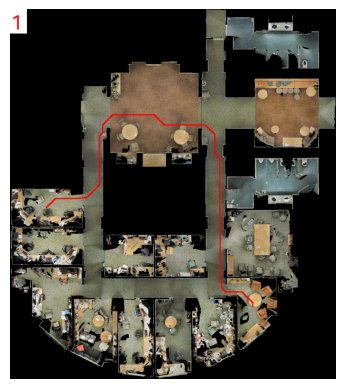

689.8301491009724
distance:  1105
277.34971503534507
distance:  1637
gpt-4o response: 
{
    "observation": "Analyze the paths through the office building from the top-view maps provided for transporting a classified file.",
    "reason": "Path 1 is selected as the most optimal route for transporting the classified file. This path avoids the central, more populated and busy areas of the office, thus minimizing exposure to unnecessary human interaction and maintaining a higher level of confidentiality and security. Path 0, in contrast, passes through more central areas which likely have higher foot traffic and less privacy, increasing the risk of accidental exposure of the classified file.",
    "self-critique": "The decision heavily relies on the assumption that less central paths are less populated. Without specific data on foot traffic patterns or the exact nature of the classified file's sensitivity, this assumption might not fully align with actual conditions. Further analysis with

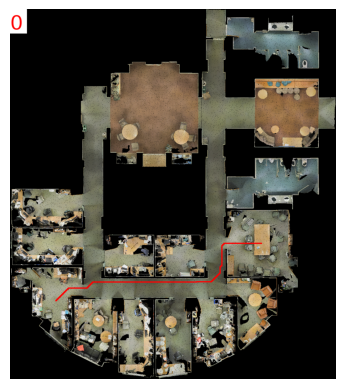

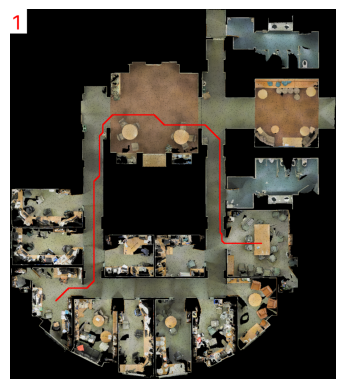

472.8240978532047
distance:  912
468.7896386865141
distance:  1789
gpt-4o response: 
{
    "observation": "Analyzing the two paths provided in the top-view maps, each path traverses different areas of the office space. Path 0 takes a more direct route through the central office areas, while Path 1 circumvents the central offices and passes through less crowded areas near the perimeter.",
    "reason": "Considering the transportation of fragile equipment, Path 1 is the preferred choice. This path avoids the busier central office areas, which reduces the risk of accidental bumps or disturbances that could potentially damage the fragile equipment. Additionally, Path 1 likely encounters fewer doorways and tighter spaces, further minimizing risk. Although Path 0 is shorter, the increased traffic and risk in the central office areas make it less suitable for transporting delicate items.",
    "self-critique": "The decision heavily relies on assumptions about traffic and disturbances without 

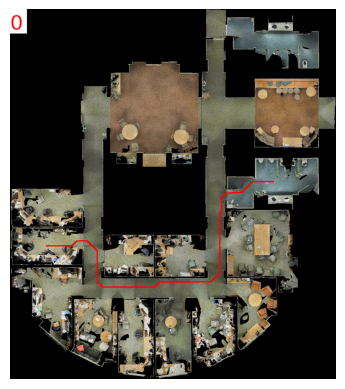

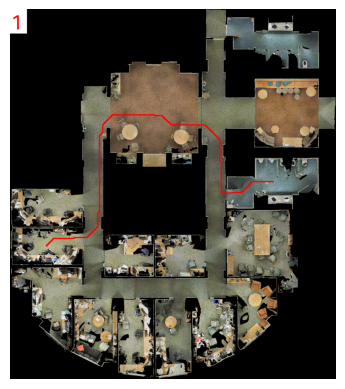

714.4052994245621
distance:  1311
194.83149911191953
distance:  1482
gpt-4o response: 
{
    "observation": "Both paths, 0 and 1, provide routes from the office to the bathroom. Path 0 takes a longer route, winding through multiple office spaces and open areas, potentially encountering more human activity. Path 1 is more direct, mostly avoiding densely populated office areas and minimizing exposure.",
    "reason": "Path 1 is selected because it offers a shorter and more private route, which is crucial for transporting private medicine. It avoids unnecessary exposure to busy office areas, thus maintaining privacy and reducing the risk of human interaction. Path 0, while also viable, passes through more populated office spaces, increasing the risk of privacy breaches.",
    "self-critique": "The analysis could be improved by having more detailed information about the times when these areas are most populated, which would further refine the path selection based on human activity patterns

In [11]:
import chat_utils
import ast
import concurrent.futures
from collections import Counter
import system_prompt
importlib.reload(chat_utils)
importlib.reload(system_prompt)

num_samples = 5
navigation_instruct1 = "send a classified file from an office to another office"
navigation_instruct2 = "send a fragile equipment from an office to a conference room"
navigation_instruct3 = "send a private medicine from an office to the bathroom"
navigation_instruct4 = "send an emergency file from an office to another office"

source_nodes = ["office_1", "office_8", "office_2"]
target_nodes = ["office_3", "conferenceRoom_1", "WC_2"]

total_shortest_score = 0
total_shortest_distance = 0
total_privacy_score = 0
total_privacy_distance = 0
for source_node, target_node in zip(source_nodes, target_nodes):
    candidate_map_list, all_geo_paths = get_all_candidate_maps(source_node, target_node)
    p_v, dis = get_metric(source_node, target_node, all_geo_paths)
    
    index = dis.index(min(dis))
    total_shortest_score += p_v[index]
    total_shortest_distance += dis[index]
    
    navigation_instruct = navigation_instruct1
    if "conference" in target_node:
        navigation_instruct = navigation_instruct2
    elif "WC" in target_node:
        navigation_instruct = navigation_instruct3
    message = chat_utils.message_prepare(system_prompt.prompt, candidate_map_list, navigation_instruct)
            
    response_message = chat_utils.chat_with_gpt4v(message)
    ground_json = ast.literal_eval(response_message)
    print(ground_json["path_id"])
    index = int(ground_json["path_id"])
    
    responses = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_message = {executor.submit(chat_utils.chat_with_gpt4v, message): message for _ in range(num_samples)}
        for future in concurrent.futures.as_completed(future_to_message):
            prompt = future_to_message[future]
            try:
                response = future.result()
                responses.append(response)
            except Exception as exc:
                print(f'{prompt} generated an exception: {exc}')

    id_list = []
    for i, response in enumerate(responses):
        ground_json = ast.literal_eval(response)
        id_list.append(int(ground_json["path_id"])) 
    print(id_list)
            
    counter = Counter(id_list)

    index, count = counter.most_common(1)[0]
    print("select ", index)
    total_privacy_score += p_v[index]
    total_privacy_distance += dis[index]
    
    
print("A* baseline result: ")
print("total_shortest_score: ", total_shortest_score)
print("total_shortest_distance: ", total_shortest_distance)

print("PAN baseline result: ")
print("total_privacy_score: ", total_privacy_score)
print("total_privacy_distance: ", total_privacy_distance)
    
    